# Starbucks Promotional Offers Data Project (Modelling Notebook)

In [1]:
# Import Python data modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sqlalchemy import create_engine

# Import modelling functions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, make_scorer

## Data Import and Preperation

In [2]:
# Create a connection to the MySQL database
user = 'root'
hidden = 'Basketba11isgood' 
host = 'localhost'
port = '3306'
database = 'starbucks_promotions_db'

connection = create_engine(f'mysql+mysqlconnector://{user}:{hidden}@{host}:{port}/{database}')

# Read in data from the SQL Database
offers = pd.read_sql('SELECT * FROM offers', con=connection)
customers = pd.read_sql('SELECT * FROM customers', con=connection)
transactions = pd.read_sql('SELECT * FROM transactions', con=connection)
offers_received = pd.read_sql('SELECT * FROM offers_received', con=connection)
offers_viewed = pd.read_sql('SELECT * FROM offers_viewed', con=connection)
offers_completed = pd.read_sql('SELECT * FROM offers_completed', con=connection)

In [3]:
# Check the primary table that will be used for modelling
customers.head(3)

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,None,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,None,NaN,NaN


The model will try to predict whether customers will complete any offer. Since the `customers` table has a row per customer, this table is at the correct granularity. The missing values in the `gender`, `age`, and `income` values will also need to be dealt with. However, this should be done after splitting the data

In [4]:
# Bin the became_member_on column by extracting just the year
customers['became_member_on_year'] = customers['became_member_on'].dt.year

### Defining a Target

In [5]:
# Create a DataFrame that says how many times each customer completed an offer sent to them
num_completed = (offers_completed.groupby('customer_id')[['offer_id']]
                                 .count()
                                 .rename({'offer_id': 'num_completed'}, axis=1)
                                 .reset_index()
                )

# Add the num_completed column to the customers table by merging the two DataFrames
customers = customers.merge(num_completed, how='left', on='customer_id')

# Change the num_completed column to be binary (1 if customer completed an offer, 0 if not)
customers['num_completed'] = np.where(customers['num_completed'] > 0, 1, 0)

# Rename the column to represent this change
customers = customers.rename({'num_completed': 'completed'}, axis=1)

In [6]:
# Check the target (completed column) distribution to see if there are any imbalances
customers['completed'].value_counts(normalize=True)

completed
1    0.751412
0    0.248588
Name: proportion, dtype: float64

The target is unbalanced. May need to use balancing methods

## Exploratory Data Analysis

### Exploring the Features

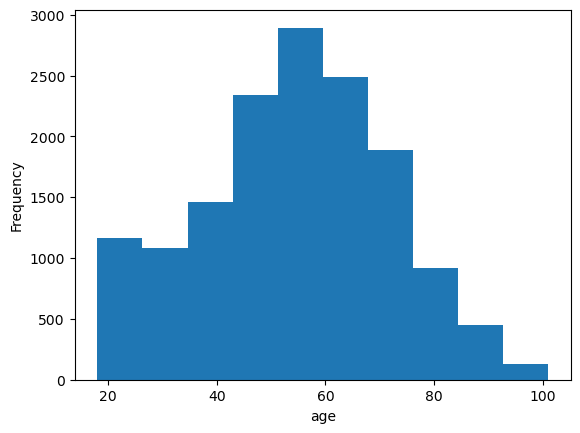

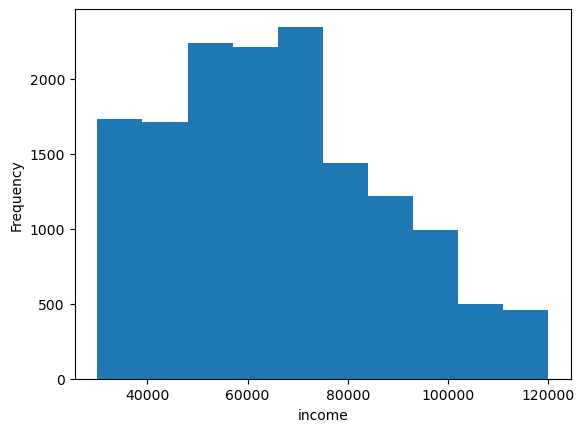

In [7]:
# See the distribution of each numeric feature by plotting histograms
for column in ['age', 'income']:
    customers[column].plot.hist()
    plt.xlabel(column)
    plt.show()

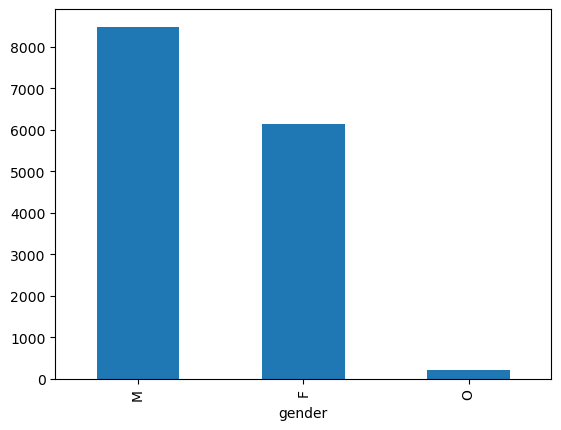

In [8]:
# See the distribution of each categorical feature by plotting bar charts
customers['gender'].value_counts().plot.bar()
plt.show()

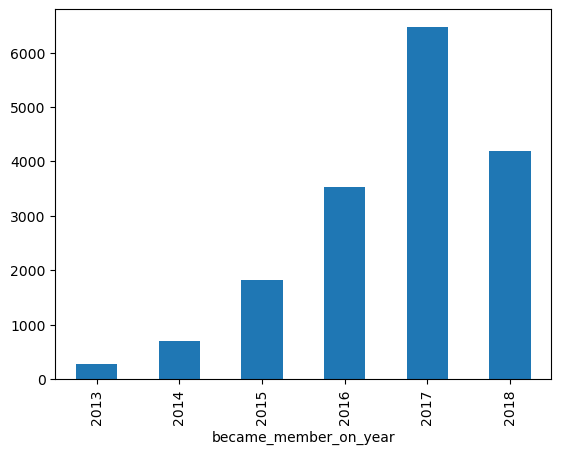

In [9]:
customers['became_member_on_year'].value_counts().sort_index().plot.bar()
plt.show()

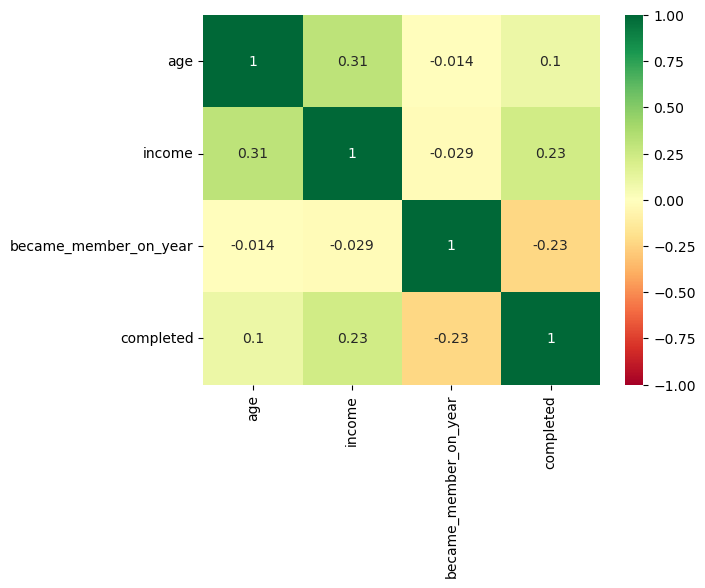

In [10]:
# Explore the correlation of the numeric variables
sns.heatmap(
    customers.corr(numeric_only=True), 
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='RdYlGn'
);

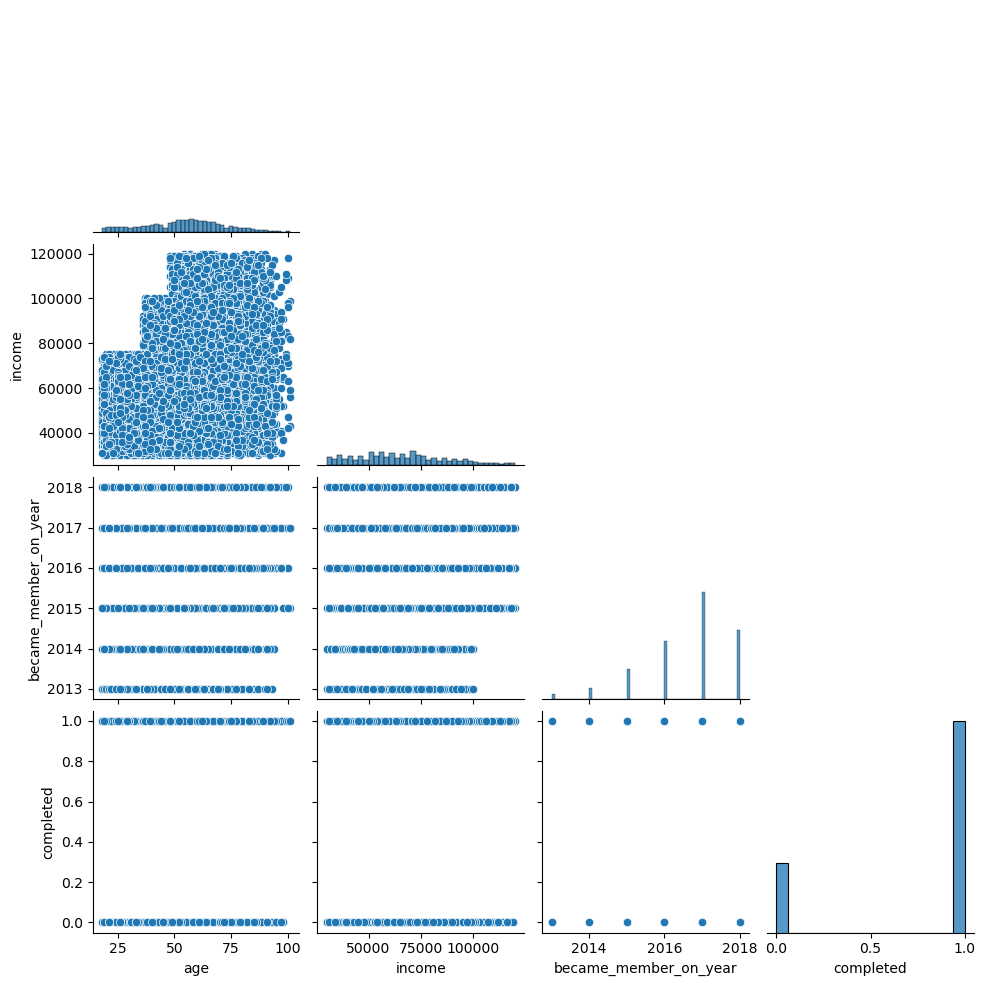

In [11]:
# Look at the relationships between the numeric variables
sns.pairplot(customers, corner=True);

### Explore Feature-Target Relationships

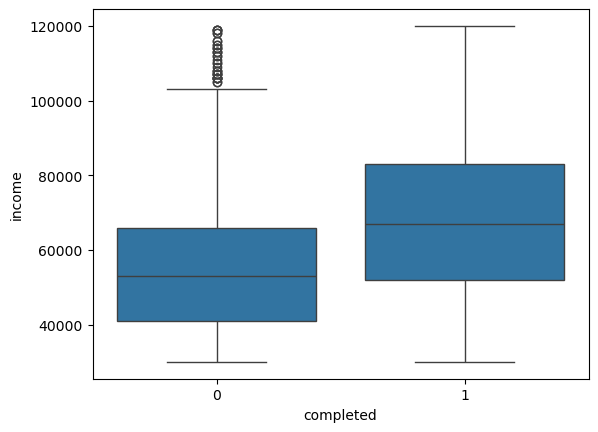

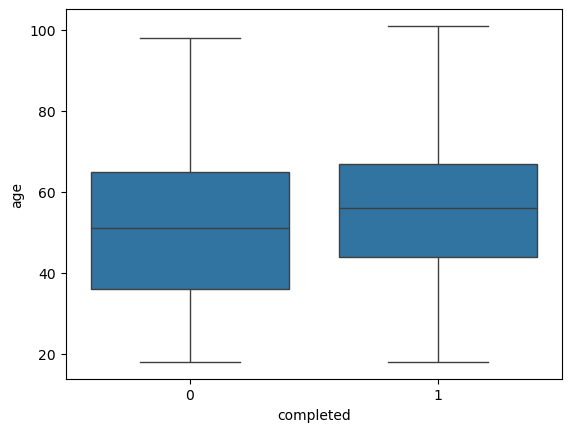

In [12]:
for column in ['income', 'age']:  #.select_dtypes(include='number').drop(['completed', 'missing'], axis=1):
    sns.boxplot(customers, x='completed', y=column)
    plt.show()

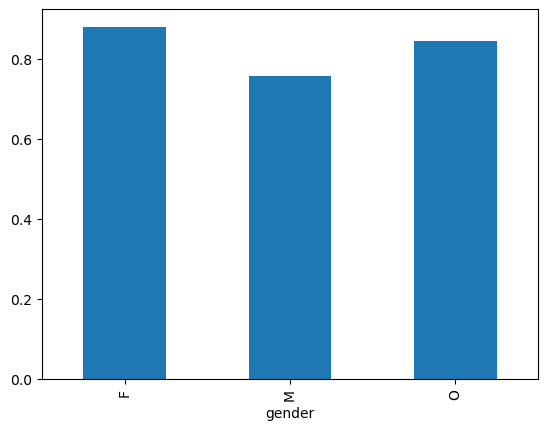

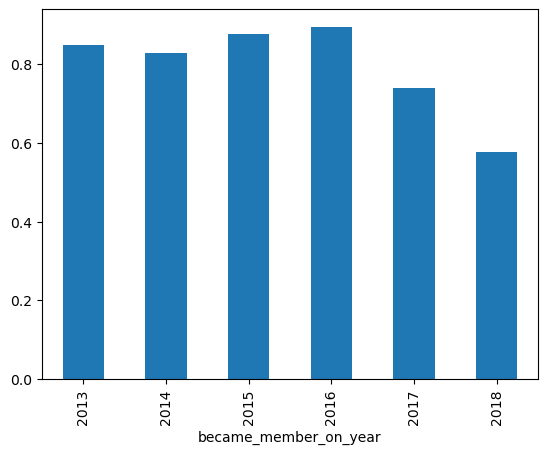

In [13]:
for column in ['gender', 'became_member_on_year']:
    customers.groupby(column)['completed'].mean().plot.bar()
    plt.show()

## Modelling Preperation

### Train & Test Data Splitting

In [14]:
# Create a copy of the customers DataFrame so we can easily go back and look at the base customers table if needed
model = customers.copy()

In [15]:
# Split the data into a train and test set before model prep to ensure unbiased testing
X = model.drop('completed', axis=1)
y = model['completed']

X_temp, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    train_size=0.9,
    test_size=0.1,
    random_state=42, 
    stratify=y
)

### Cleaning for Modelling

Need to deal with the missing values for `income`, `age`, and `gender` columns

In [16]:
# Fill in the missing values with the median for the age and income columns
for column in ['age', 'income']:
    X_temp[column] = X_temp[column].fillna(X_temp[column].median())

In [17]:
# Check the distribution of gender values
X_temp['gender'].value_counts(normalize=True, dropna=False)

gender
M       0.498235
F       0.360261
None    0.128824
O       0.012680
Name: proportion, dtype: float64

In [18]:
# Add a 'Missing' value for None values
X_temp['gender'] = X_temp['gender'].fillna('Missing')

In [19]:
# Turn the categorical variables (just gender in this case) into dummy variables
X_temp = pd.get_dummies(
    X_temp,
    columns=['gender'],
    drop_first=True,
    dtype='int'
)

In [20]:
# Check the modelling DataFrame
X_temp.head()

,customer_id,became_member_on,age,income,became_member_on_year,gender_M,gender_Missing,gender_O
8265,32a0f871e17c4cfdb238a3da76ec0cb8,2016-01-01,77.0,46000.0,2016,0,0,0
3058,2cd61834c34d4127b161568aa8104d10,2017-11-21,33.0,53000.0,2017,0,0,0
1879,d5299e0003e44a11858e28bc4fd86d0c,2016-02-14,55.0,64000.0,2016,0,1,0
8770,0eed1b43c7924182a635f0597fdf2adf,2018-01-06,54.0,42000.0,2018,1,0,0
854,b8c17e6e004746a4800eeac73461b1dd,2017-08-04,63.0,96000.0,2017,1,0,0


### Feature Engineering

In [21]:
X_temp.head(2)

,customer_id,became_member_on,age,income,became_member_on_year,gender_M,gender_Missing,gender_O
8265,32a0f871e17c4cfdb238a3da76ec0cb8,2016-01-01,77.0,46000.0,2016,0,0,0
3058,2cd61834c34d4127b161568aa8104d10,2017-11-21,33.0,53000.0,2017,0,0,0


In [22]:
num_received = (offers_received.groupby('customer_id')
                               .count()
                               .reset_index()
                               [['customer_id', 'offer_id']]
                               .rename(
                                   {'offer_id': 'num_received'}, 
                                   axis=1
                               )
               )

X_temp = X_temp.merge(
    num_received,
    how='left',
    on='customer_id'
).fillna(0)

### Train & Validation Data Splitting

In [23]:
# Make a copy of the target Series
y = y_train.copy()

# Drop the customer identifier column
model = model.drop('customer_id', axis=1)

In [24]:
# Chose the features
X = X_temp[[
        #'became_member_on'
        'became_member_on_year',
        'age',
        'income',
        'gender_M',
        'gender_Missing',
        'gender_O',
        'num_received'
]]

# Split the train data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=2/9,
    random_state=42, 
    stratify=y
)

# Create standardised datasets if needed for particular models
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_val_std = std.fit_transform(X_val)

## Modelling

In [25]:
def scoring(model, X, y, threshold=0.5):
    """
    Prints out a confusion matrix and ROC curve and prints the accuracy score, precision score, recall score, 
    f1 score, and AUC of a classification model.
    
    Inputs:
        model: Classification model (fitted sklearn Evaluation Object)
        X: Features (pd.DataFrame)
        y: Actual target values for features (pd.Series)

    Returns:
        None
    """
    # Get the predicted values of the model
    predicted_y_values = model.predict_proba(X)[:, 0] < threshold

    # Build a confusion matrix
    sns.heatmap(
        confusion_matrix(y, predicted_y_values),
        cmap='Blues',
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['None Completed', 'Completed'],
        yticklabels=['None Completed', 'Completed'],
    ).set(
        xlabel='Actual',
        ylabel='Predicted',
        title='Confusion_Matrix'
    )
    plt.show()
    plt.clf()

    # Build an ROC curve with AUC score
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 0], pos_label=0)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Model (AUC Score: {auc_score:.2f})')
    plt.plot([0,1], [0,1], color='Black', linestyle='--', label='Random Guess (AUC Score: 0.50)')
    plt.xlabel('False Positive Rate'),
    plt.ylabel('True Positive Rate'),
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    plt.clf()

    # Print out scoring metrics
    print(f'Accuracy Score: {accuracy_score(y, predicted_y_values)}')
    print(f'Precision Score: {precision_score(y, predicted_y_values, pos_label=0)}')
    print(f'Recall Score: {recall_score(y, predicted_y_values, pos_label=0)}')
    print(f'f1 Score: {f1_score(y, predicted_y_values, pos_label=0)}')

### K-Nearest Neighbours Model

In [26]:
params = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    KNeighborsClassifier(), 
    params,
    scoring=make_scorer(f1_score, pos_label=0),
    n_jobs=1,
    cv=5,
    verbose=1
)
grid.fit(X_train_std, y_train)
grid.best_params_

Fitting 5 folds for each of 196 candidates, totalling 980 fits


{'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}

In [27]:
knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=14)

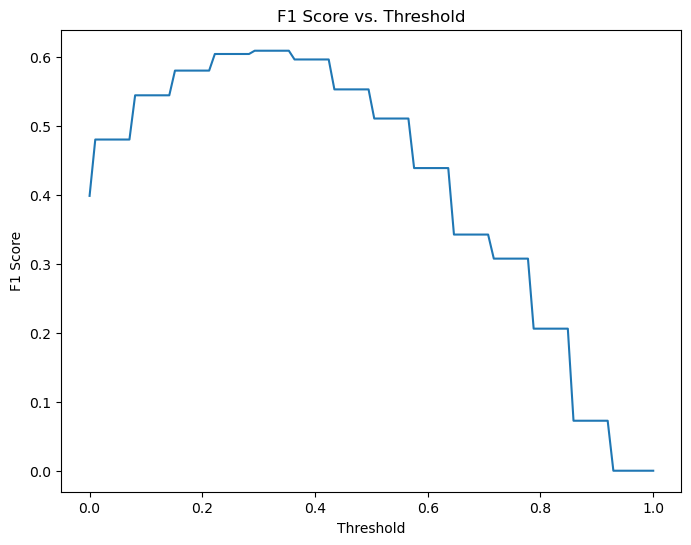

In [28]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    f1_scores.append(f1_score(y_train, knn.predict_proba(X_train_std)[:, 0] < threshold, pos_label=0))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

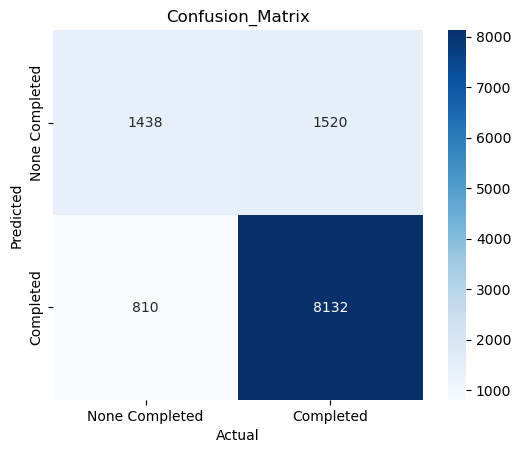

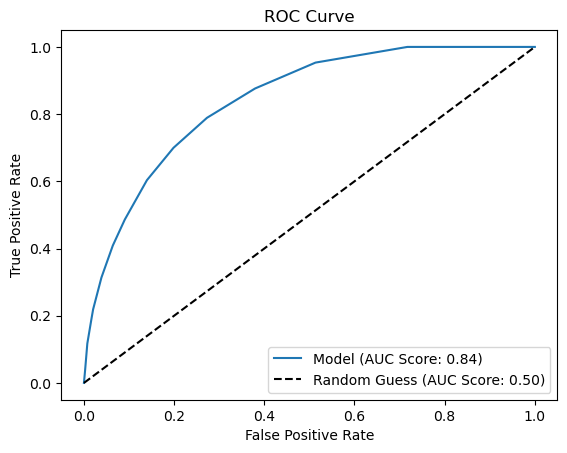

Accuracy Score: 0.8042016806722689
Precision Score: 0.6396797153024911
Recall Score: 0.4861392832995267
f1 Score: 0.552439492892816


<Figure size 640x480 with 0 Axes>

In [29]:
scoring(knn, X_train_std, y_train)

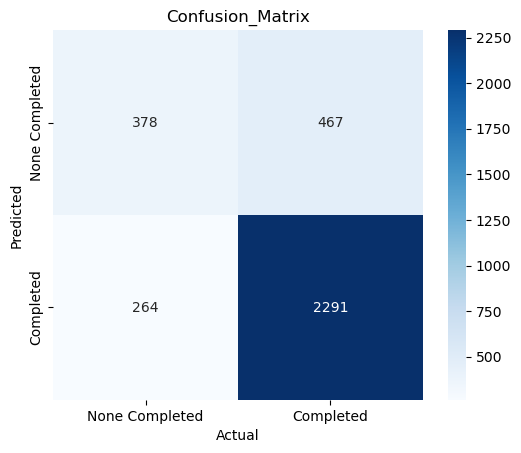

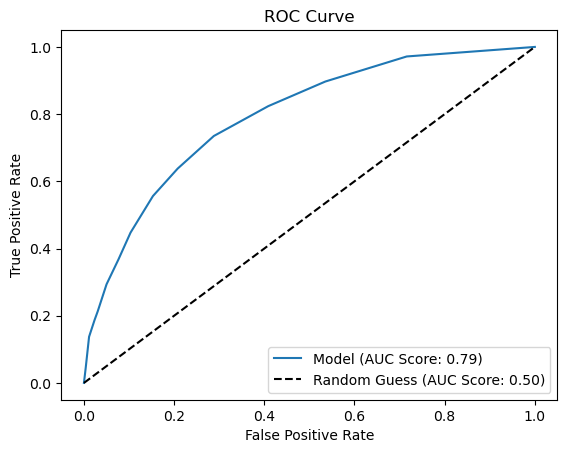

Accuracy Score: 0.785
Precision Score: 0.5887850467289719
Recall Score: 0.44733727810650886
f1 Score: 0.5084061869535978


<Figure size 640x480 with 0 Axes>

In [30]:
scoring(knn, X_val_std, y_val)

### Logistic Regression

In [31]:
params = {
    'C': np.linspace(0.1, 2, 20),
    'penalty': ['l1', 'l2'],
}

grid = GridSearchCV(LogisticRegression(solver='saga'), params)
grid.fit(X_train_std, y_train)
grid.best_params_

{'C': 0.7, 'penalty': 'l2'}

In [32]:
lr = LogisticRegression(**grid.best_params_, solver='saga')
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.7, solver='saga')

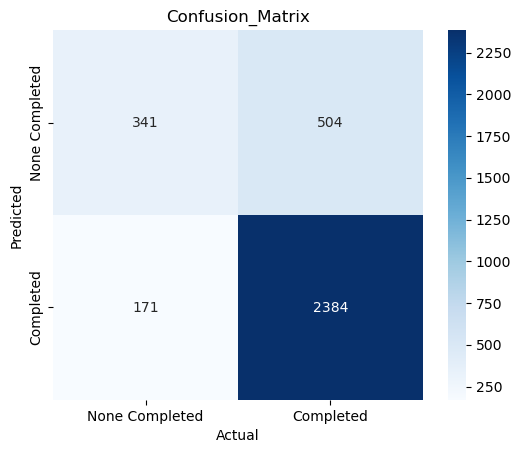

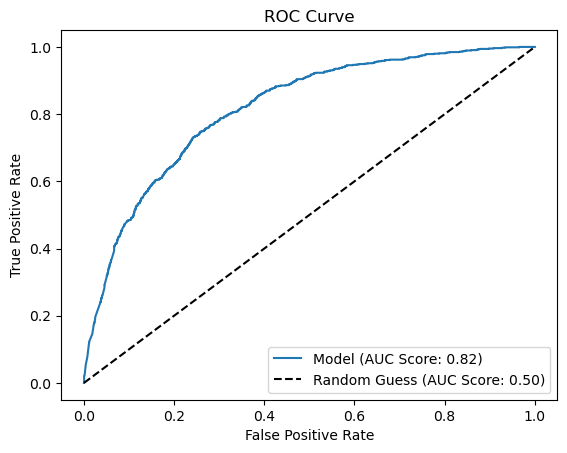

Accuracy Score: 0.8014705882352942
Precision Score: 0.666015625
Recall Score: 0.4035502958579882
f1 Score: 0.5025792188651437


<Figure size 640x480 with 0 Axes>

In [33]:
scoring(lr, X_val_std, y_val)